In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
from plotly.subplots import make_subplots
from sklearn import preprocessing
import random
import warnings
warnings.filterwarnings("ignore")


In [4]:
def Create_directory_DataFrame():
  df = pd.DataFrame(columns = ['Class','Location'])
  basedir = "/content/drive/MyDrive/HGM-4/HGM-1.0/"
  for folder in os.listdir(basedir):
    for Class in os.listdir(basedir + folder + '/'):
      for loc in os.listdir(basedir + folder+ '/'  + Class + '/'):
        df = df.append({'Class':Class,'Location':basedir + folder+ '/' + Class + '/'+ loc},ignore_index = True)
  df = df.sample(frac = 1)
  return df

In [5]:
df = Create_directory_DataFrame()
print(df.shape)
df.head()

(4170, 2)


,Class,Location
791,K,/content/drive/MyDrive/HGM-4/HGM-1.0/Left_CAM/...
1293,Q,/content/drive/MyDrive/HGM-4/HGM-1.0/Right_CAM...
2245,V,/content/drive/MyDrive/HGM-4/HGM-1.0/Front_CAM...
1650,N,/content/drive/MyDrive/HGM-4/HGM-1.0/Right_CAM...
52,W,/content/drive/MyDrive/HGM-4/HGM-1.0/Left_CAM/...


In [6]:
df.Class.unique().size

26

Visualizing Data

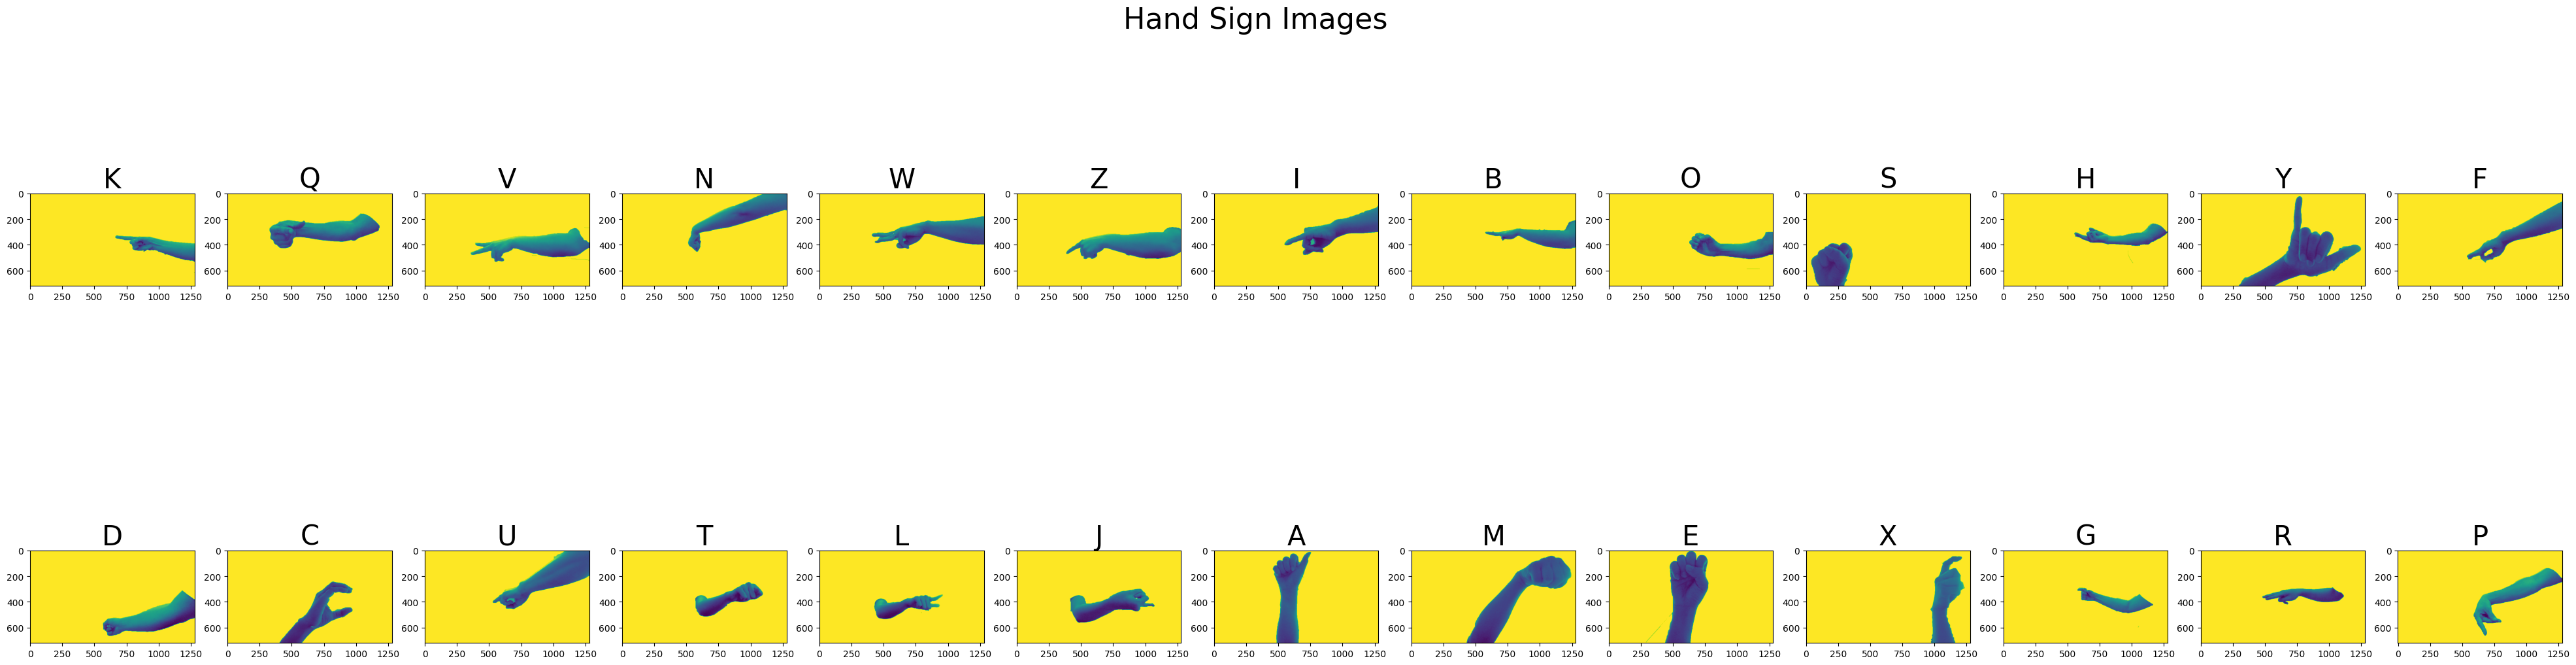

In [7]:
count = 1
f = plt.figure(figsize=(50,13))
for Class in df['Class'].unique():
    seg = df[df['Class']==Class]
    address =  seg.sample().iloc[0]['Location']
    img = cv2.imread(address,0,)
    ax = f.add_subplot(2, 13,count)
    ax = plt.imshow(img)
    ax = plt.title(Class,fontsize= 30)
    count = count + 1
plt.suptitle("Hand Sign Images", size = 32)
plt.show()

In [8]:
img.shape

(720, 1280)

In [9]:
# Defining Constraints:
w,h = 64,64
final_class = 26

**Data Creation:\\**

In [11]:
from tqdm import tqdm
train_image = []
for location in tqdm(df.iloc[:]['Location']):
  img = cv2.imread(location,0)
  img = cv2.resize(img,(w,h),interpolation=cv2.INTER_AREA)
  img = img.reshape(w,h,1)
  train_image.append(img)
X = np.array(train_image)

100%|██████████| 4170/4170 [18:53<00:00,  3.68it/s]


In [12]:
from sklearn.preprocessing import OneHotEncoder
y = np.array(df.iloc[:]['Class'])
y = y.reshape(y.shape[0],1)
enc = OneHotEncoder(handle_unknown = "ignore")
enc.fit(y)
# print(enc.categories)
print(enc.categories_)

[array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
      dtype=object)]


In [14]:
y = enc.transform(y).toarray()

In [64]:

print('Data   :   '+str(X.shape))
print('Output :   '+str(y.shape))

Data   :   (4170, 64, 64, 1)
Output :   (4170, 26)


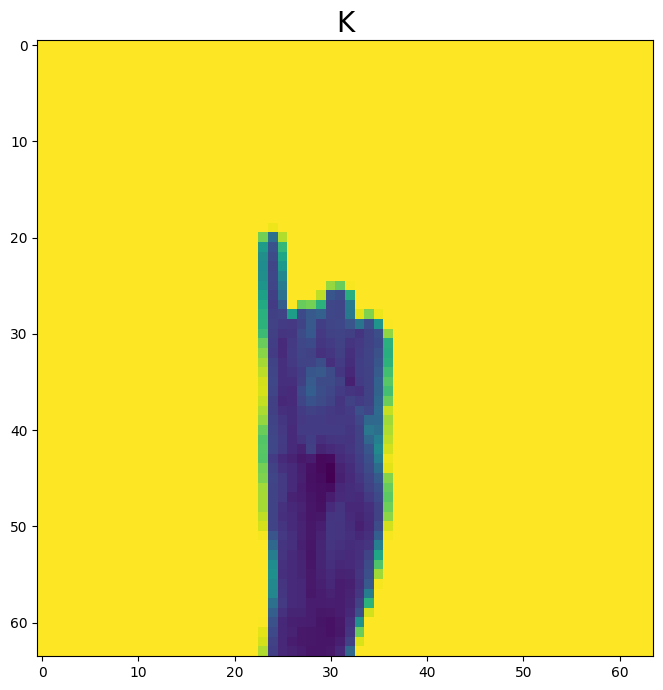

In [15]:
plt.figure(figsize = (25,8))
plt.imshow(X[66].reshape(w,h))
plt.title(enc.inverse_transform(y[0].reshape(1,26))[0][0],size = 20)
plt.show()

Segmentation in training and test data

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42,test_size = 0.2,stratify = y)

In [65]:
print('Train data    :'+str(X_train.shape))
print('Test data     :'+str(X_test.shape))
print('Train Output  :'+str(y_train.shape))
print('Test Output   :'+str(y_test.shape))

Train data    :(3336, 64, 64, 1)
Test data     :(834, 64, 64, 1)
Train Output  :(3336, 26)
Test Output   :(834, 26)


MODEL

In [17]:
# Model Blocks:
def conv_block(filters):
  block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters,3,activation='relu',padding = 'same'),
      tf.keras.layers.SeparableConv2D(filters,3,activation='relu',padding = 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ])

  return block

def dense_block(units,dropout_rate):
  block = tf.keras.Sequential([
      tf.keras.layers.Dense(units,activation = 'relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)
  ])

  return block


def build_model(act,final_class,w,h):
  model = tf.keras.Sequential([
      tf.keras.Input(shape = (w,h,1)),
      tf.keras.layers.Conv2D(16,3,activation=act,padding= 'same'),
      tf.keras.layers.Conv2D(16,3,activation=act,padding= 'same'),
      tf.keras.layers.MaxPool2D(),
      conv_block(32),
      conv_block(64),

      conv_block(128),
      tf.keras.layers.Dropout(0.2),

      conv_block(256),
      tf.keras.layers.Dropout(0.2),

      tf.keras.layers.Flatten(),
      dense_block(512,0.7),
      dense_block(128,0.5),
      dense_block(64,0.3),

      tf.keras.layers.Dense(final_class,activation='sigmoid')
  ])

  return model


In [18]:
def wrap(Training_Output_Results,Opt,Act,history):
  epoch = len(history.history['loss'])
  epochs = list(np.arange(1,epoch+1,1))
  Optimizer = np.repeat(Opt,epoch).tolist()
  Activation = np.repeat(Act,epoch).tolist()
  cumiliated_res = {}
  cumiliated_res['Epochs']= epochs
  cumiliated_res['Optimizer'] = Optimizer
  cumiliated_res['Activation_Function']  = Activation
  cumiliated_res['Train_Loss'] = history.history['loss']
  cumiliated_res['Train_Accuracy'] = history.history['accuracy']
  cumiliated_res['Train_Precision'] = history.history['precision']
  cumiliated_res['Train_Recall'] = history.history['recall']
  cumiliated_res['Val_Loss'] = history.history['val_loss']
  cumiliated_res['Val_Accuracy'] = history.history['val_accuracy']
  cumiliated_res['Val_Precision']=history.history['val_precision']
  cumiliated_res['Val_Recall']=history.history['val_recall']
  convertDict = pd.DataFrame(cumiliated_res)
  Training_Output_Results = Training_Output_Results.append(convertDict)

  return Training_Output_Results

In [22]:
Optimizers = ['RMSprop','Adam','Adadelta','Adagrad']
Activation_Functions = ['relu','sigmoid','softmax','tanh','softsign','selu','elu']

---------------------------------------------------------------------------------------------------------------------------------------------

OPTIMIZER ANALYTICS

In [25]:
Training_Output_Results =pd.DataFrame(columns=['Epochs','Optimizer','Activation_Function','Train_Loss','Train_Accuracy','Train_Precision','Train_Recall','Val_Loss','Val_Accuracy','Val_Precision','Val_Recall'])

def Optimize_verify(Training_Output_Results):
  for opt in Optimizers:
    model = build_model(Activation_Functions[0],final_class,w,h)
    METRICS = [
                'accuracy',
                tf.keras.metrics.Precision(name = 'precision'),
                tf.keras.metrics.Recall(name = 'recall')
    ]
    model.compile(
        optimizer = opt,
        loss = 'categorical_crossentropy',
        metrics = METRICS
    )
    history = model.fit(X_train,y_train,epochs = 10,validation_split = 0.3,batch_size = 15,verbose = 1,shuffle = True)
    Training_Output_Results = wrap(Training_Output_Results,opt,Activation_Functions[0],history)
    print("Done for " + opt )
  return Training_Output_Results

Training_Output_Results = Optimize_verify(Training_Output_Results)


Epoch 1/10
156/156 [==============================] - 14s 24ms/step - loss: 3.9134 - accuracy: 0.0441 - precision: 0.0396 - recall: 0.5143 - val_loss: 3.3218 - val_accuracy: 0.0350 - val_precision: 0.0382 - val_recall: 0.5345
Epoch 2/10
156/156 [==============================] - 2s 14ms/step - loss: 3.7559 - accuracy: 0.0407 - precision: 0.0377 - recall: 0.4887 - val_loss: 3.3105 - val_accuracy: 0.0320 - val_precision: 0.0384 - val_recall: 0.5754
Epoch 3/10
156/156 [==============================] - 3s 19ms/step - loss: 3.5809 - accuracy: 0.0407 - precision: 0.0396 - recall: 0.5191 - val_loss: 3.3042 - val_accuracy: 0.0370 - val_precision: 0.0389 - val_recall: 0.6653
Epoch 4/10
156/156 [==============================] - 2s 13ms/step - loss: 3.4613 - accuracy: 0.0488 - precision: 0.0396 - recall: 0.5366 - val_loss: 3.3966 - val_accuracy: 0.0410 - val_precision: 0.0395 - val_recall: 0.8422
Epoch 5/10
156/156 [==============================] - 2s 13ms/step - loss: 3.3909 - accuracy: 0.042

In [26]:
Training_Output_Results = Training_Output_Results.sample(frac = 1)
print(Training_Output_Results.shape)
Training_Output_Results.to_csv('Optimizer_64*64.csv',index = False)
Training_Output_Results.head()

(40, 11)


,Epochs,Optimizer,Activation_Function,Train_Loss,Train_Accuracy,Train_Precision,Train_Recall,Val_Loss,Val_Accuracy,Val_Precision,Val_Recall
8,9,Adadelta,relu,4.202672,0.031692,0.038538,0.500214,3.374346,0.037962,0.040084,0.569431
7,8,Adam,relu,3.311365,0.051820,0.042833,0.553319,3.246309,0.053946,0.042254,0.533467
0,1,Adadelta,relu,4.181376,0.043255,0.037815,0.494218,3.331768,0.041958,0.038890,0.544456
6,7,Adam,relu,3.326572,0.050964,0.042110,0.537473,3.272782,0.035964,0.040731,0.503497
8,9,RMSprop,relu,3.244080,0.067666,0.041408,0.610707,3.199470,0.072927,0.039833,0.677323


ACTIVATION ANALYTICS

In [23]:
print(Activation_Functions)

['relu', 'sigmoid', 'softmax', 'tanh', 'softsign', 'selu', 'elu']


In [27]:
Training_Output_Results = pd.DataFrame(columns = ['Epochs','Optimizer','Activation_Function','Train_Loss','Train_Accuracy','Train_Precision','Train_Recall','Val_Loss','Val_Accuracy','Val_Precision','Val_Recall'])
def Activation_verify(Training_Output_Results):
  for act in Activation_Functions:
    model = build_model(act,final_class,w,h)
    METRICS = [
              'accuracy',
              tf.keras.metrics.Precision(name = 'precision'),
              tf.keras.metrics.Recall(name = 'recall')
    ]
    model.compile(
        optimizer = Optimizers[0],
        loss = 'categorical_crossentropy',
        metrics = METRICS
    )
    history = model.fit(X_train,y_train,epochs = 10,validation_split = 0.3,batch_size = 15,verbose = 1,shuffle = True)
    Training_Output_Results = wrap(Training_Output_Results,Optimizers[0],act,history)
    print("done for " + act+ "\n")
  return Training_Output_Results

Training_Output_Results = Activation_verify(Training_Output_Results)


Epoch 1/10
156/156 [==============================] - 7s 16ms/step - loss: 3.9323 - accuracy: 0.0403 - precision: 0.0390 - recall: 0.5118 - val_loss: 3.3208 - val_accuracy: 0.0310 - val_precision: 0.0387 - val_recall: 0.6963
Epoch 2/10
156/156 [==============================] - 3s 19ms/step - loss: 3.7312 - accuracy: 0.0411 - precision: 0.0387 - recall: 0.5126 - val_loss: 3.3121 - val_accuracy: 0.0370 - val_precision: 0.0388 - val_recall: 0.8541
Epoch 3/10
156/156 [==============================] - 2s 14ms/step - loss: 3.5410 - accuracy: 0.0403 - precision: 0.0395 - recall: 0.5409 - val_loss: 3.3440 - val_accuracy: 0.0350 - val_precision: 0.0391 - val_recall: 0.8262
Epoch 4/10
156/156 [==============================] - 2s 12ms/step - loss: 3.4876 - accuracy: 0.0415 - precision: 0.0387 - recall: 0.5512 - val_loss: 3.4544 - val_accuracy: 0.0350 - val_precision: 0.0359 - val_recall: 0.0340
Epoch 5/10
156/156 [==============================] - 2s 13ms/step - loss: 3.4190 - accuracy: 0.0343

In [28]:
Training_Output_Results = Training_Output_Results.sample(frac = 1)
print(Training_Output_Results.shape)

Training_Output_Results.to_csv('Activation_64*64_data.csv', index = False)
Training_Output_Results.head()


(70, 11)


,Epochs,Optimizer,Activation_Function,Train_Loss,Train_Accuracy,Train_Precision,Train_Recall,Val_Loss,Val_Accuracy,Val_Precision,Val_Recall
9,10,RMSprop,softsign,3.262897,0.044968,0.039963,0.589722,3.475484,0.040959,0.023810,0.001998
9,10,RMSprop,sigmoid,3.240383,0.060814,0.041611,0.605567,5.251967,0.035964,0.033548,0.025974
5,6,RMSprop,selu,3.370477,0.039400,0.040016,0.555889,3.253613,0.048951,0.039661,0.892108
0,1,RMSprop,softmax,3.959502,0.044111,0.038332,0.496788,3.314115,0.043956,0.040493,0.607393
8,9,RMSprop,softmax,3.309988,0.044111,0.039247,0.473233,3.339227,0.041958,0.000000,0.000000


PLOTTING:

In [29]:
opt = pd.read_csv('Optimizer_64*64.csv')
act = pd.read_csv('Activation_64*64_data.csv')

OPTIMIZATION

In [36]:
import plotly.express as px
import plotly.offline as pyo
import plotly as py
import statsmodels.api as sm
scatterplot = px.area(
                    data_frame = opt,
                    x = "Epochs",
                    y = "Train_Accuracy",
                    color = "Optimizer",
                    title = "Train_Accuracy",
                    template = 'presentation'
)

pyo.iplot(scatterplot,filename = 'Opt_train_acc')

In [66]:
scatterplot = px.area(
                  data_frame = opt,
                  x = "Epochs",
                  y = "Train_Loss",
                  color ="Optimizer",
                  title = 'Train Loss',
                  template = 'presentation'
)

pyo.iplot(scatterplot,filename = 'Opt_train_loss')

In [67]:
scatterplot = px.area(
                  data_frame = opt,
                  x = "Epochs",
                  y = "Train_Precision",
                  color = "Optimizer",
                  title = 'Train Precision',
                  template = 'presentation'
)

pyo.iplot(scatterplot,filename = 'Opt_train_prec')

In [68]:
scatterplot = px.area(
                  data_frame = opt,
                  x = "Epochs",
                  y = "Train_Recall",
                  color ="Optimizer",
                  title = 'Train Recall',
                  template = 'presentation'
)

pyo.iplot(scatterplot,filename = 'Opt_train_recall')

In [69]:
scatterplot = px.area(
                  data_frame = opt,
                  x = "Epochs",
                  y = "Val_Accuracy",
                  color ="Optimizer",
                  title = 'Validation Accuracy',
                  template = 'presentation'
)

pyo.iplot(scatterplot,filename = 'Opt_val_accuracy')

In [70]:
scatterplot = px.area(
                  data_frame = opt,
                  x = "Epochs",
                  y = "Val_Precision",
                  color ="Optimizer",
                  facet_col='Optimizer',
                  title = 'Validation Precision',
                  template = 'presentation'
)

pyo.iplot(scatterplot,filename = 'Opt_val_prec')

In [71]:
scatterplot = px.area(
                  data_frame = opt,
                  x = "Epochs",
                  y = "Val_Recall",
                  color ="Optimizer",
                  facet_col='Optimizer',
                  title = 'Validation Recall',
                  template = 'presentation'
)

pyo.iplot(scatterplot,filename = 'Opt_val_Recall')

In [73]:
scatterplot = px.area(
                  data_frame = opt,
                  x = "Epochs",
                  y = "Val_Loss",
                  color ="Optimizer",
                  title = 'Validation Loss',
                  template = 'presentation'
)

pyo.iplot(scatterplot,filename = 'Opt_val_Loss')

**Activation Functions**

In [72]:
scatterplot = px.area(
                  data_frame = act,
                  x = "Epochs",
                  y = "Train_Accuracy",
                  color ="Activation_Function",
                  title = 'Train Accuracy',
                  template = 'presentation'
)

pyo.iplot(scatterplot,filename = 'Act_train_acc')

In [74]:
scatterplot = px.area(
                  data_frame = act,
                  x = "Epochs",
                  y = "Train_Loss",
                  color ="Activation_Function",
                  title = 'Train Loss',
                  template = 'presentation'
)

pyo.iplot(scatterplot,filename = 'Act_train_loss')

In [75]:
scatterplot = px.area(
                  data_frame = act,
                  x = "Epochs",
                  y = "Train_Precision",
                  color ="Activation_Function",
                  title = 'Train Prec',
                  template = 'presentation'
)

pyo.iplot(scatterplot,filename = 'Act_train_prec')

In [76]:
scatterplot = px.area(
                  data_frame = act,
                  x = "Epochs",
                  y = "Train_Recall",
                  color ="Activation_Function",
                  title = 'Train Recall',
                  template = 'presentation'
)

pyo.iplot(scatterplot,filename = 'Act_train_Recall')

In [77]:
import plotly.graph_objects as go
tab_opt = opt[opt['Epochs']==10]
final_col = np.delete(tab_opt.columns[0:], [0,2])
fig = go.Figure(data=[go.Table(
    header=dict(values=list(final_col),
                fill_color='salmon',
                align='left'),
    cells=dict(values=[tab_opt.Optimizer , tab_opt.Train_Loss,tab_opt.Train_Accuracy,tab_opt.Train_Precision,tab_opt.Train_Recall,tab_opt.Val_Loss,tab_opt.Val_Accuracy,tab_opt.Val_Precision,tab_opt.Val_Recall],
               fill_color='lavender',
               align='left'))
])

fig.show()

In [78]:
ty = opt[opt['Epochs'] == 10].iloc[:,3:]
nm = ty.columns
ty = ty.values.tolist()
data = []

for i in range(len(nm)):
  lt = []
  for j in range(len(Optimizers)):
      lt.append(ty[j][i])

  data.append(go.Bar(name = nm[i],x = Optimizers,y = lt))
fig = go.Figure(data = data)

fig.update_layout(barmode = 'group')
fig.show()

In [79]:
tab_opt = act[act['Epochs']==10]
final_col = np.delete(tab_opt.columns[0:], [0,1])
fig = go.Figure(data=[go.Table(
    header=dict(values=list(final_col),
                fill_color='salmon',
                align='left'),
    cells=dict(values=[tab_opt.Activation_Function , tab_opt.Train_Loss,tab_opt.Train_Accuracy,tab_opt.Train_Precision,tab_opt.Train_Recall,tab_opt.Val_Loss,tab_opt.Val_Accuracy,tab_opt.Val_Precision,tab_opt.Val_Recall],
               fill_color='lavender',
               align='left'))
])

fig.show()

In [80]:
ty =act[act['Epochs']==10].iloc[:,3:]
nm = ty.columns
ty = ty.values.tolist()
data = []

for j in range(len(nm)):
        lt = []
        for i in range(len(Activation_Functions)):
            lt.append(ty[i][j])

        data.append(go.Bar(name = nm[j],x=Activation_Functions, y=lt))
fig = go.Figure(data=data)
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

**FINAL MODEL**


---







In [33]:
def Plot(history , name , model):
    model.save(name+'.h5')
    epochs = range(1,len(history.history['loss']) + 1)
    epochs = list(epochs)
    fig = make_subplots(rows=2, cols=4,subplot_titles=("Train Loss", "Train Accuracy" , "Train Precision","Train Recall", "Validation Loss", "Validation Accuracy",
                                                      "Validation Precision","Validation Recall"))
    fig.add_trace(go.Scatter(x=epochs, y=history.history['loss']), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['accuracy']), row=1, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['precision']), row=1, col=3)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['recall']), row=1, col=4)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_loss']), row=2, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_accuracy']), row=2, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_precision']), row=2, col=3)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_recall']), row=2, col=4)
    fig.update_layout(showlegend=False,height=1000, width=1200, title_text=name)
    pyo.iplot(fig, filename = 'Act_train_rec')

In [34]:
model = build_model('relu',final_class,w,h)
METRICS =   [
                'accuracy',
                tf.keras.metrics.Precision(name = 'precision'),
                tf.keras.metrics.Recall(name = 'recall')
]

model.compile(
            optimizer = 'RMSprop',
            loss = 'categorical_crossentropy',
            metrics = METRICS
)
history = model.fit(X_train,y_train,epochs = 50,validation_split = 0.3,batch_size = 15,verbose = 1,shuffle = True)


Epoch 1/50
156/156 [==============================] - 7s 16ms/step - loss: 3.9056 - accuracy: 0.0381 - precision: 0.0387 - recall: 0.5156 - val_loss: 3.3131 - val_accuracy: 0.0370 - val_precision: 0.0383 - val_recall: 0.8801
Epoch 2/50
156/156 [==============================] - 3s 18ms/step - loss: 3.6596 - accuracy: 0.0544 - precision: 0.0402 - recall: 0.5482 - val_loss: 3.3254 - val_accuracy: 0.0380 - val_precision: 0.0385 - val_recall: 0.9800
Epoch 3/50
156/156 [==============================] - 2s 15ms/step - loss: 3.5497 - accuracy: 0.0433 - precision: 0.0397 - recall: 0.5533 - val_loss: 3.3992 - val_accuracy: 0.0330 - val_precision: 0.0383 - val_recall: 0.6853
Epoch 4/50
156/156 [==============================] - 2s 13ms/step - loss: 3.4353 - accuracy: 0.0518 - precision: 0.0397 - recall: 0.5824 - val_loss: 3.2831 - val_accuracy: 0.0519 - val_precision: 0.0391 - val_recall: 0.9131
Epoch 5/50
156/156 [==============================] - 2s 12ms/step - loss: 3.3813 - accuracy: 0.0424

In [37]:
Plot(history,'final_model',model)

In [39]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 7.4 MB/s eta 0:00:00


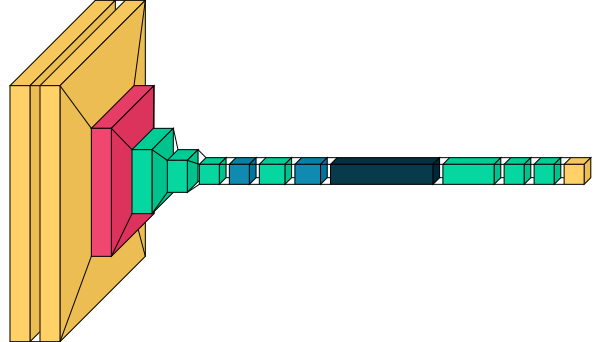

In [40]:
import visualkeras
visualkeras.layered_view(model)

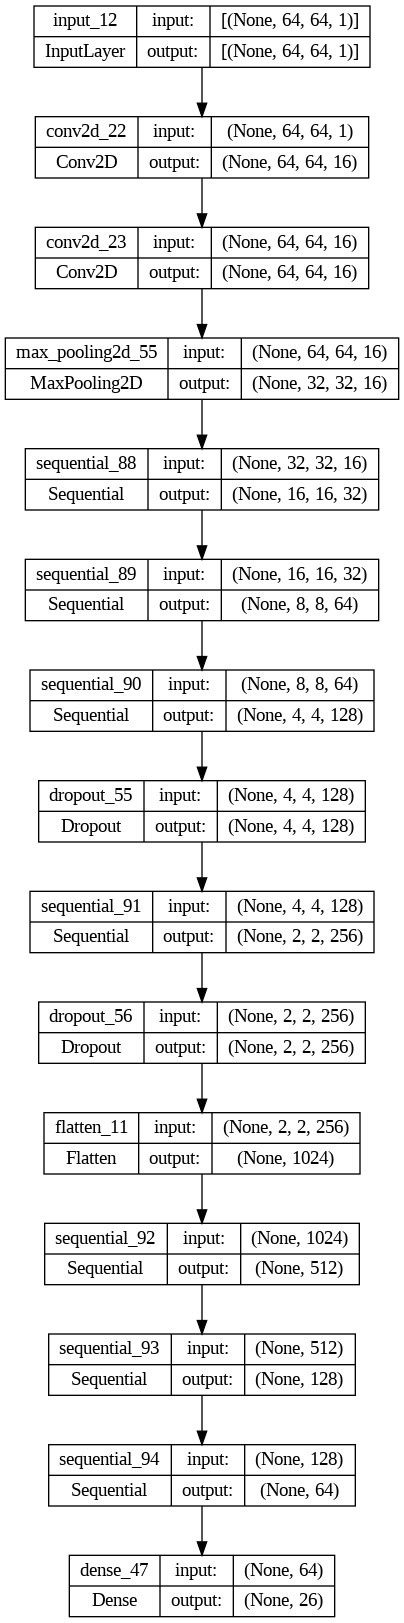

In [41]:
from keras.utils import plot_model
plot_model(model,to_file = 'model.png',show_shapes = True)

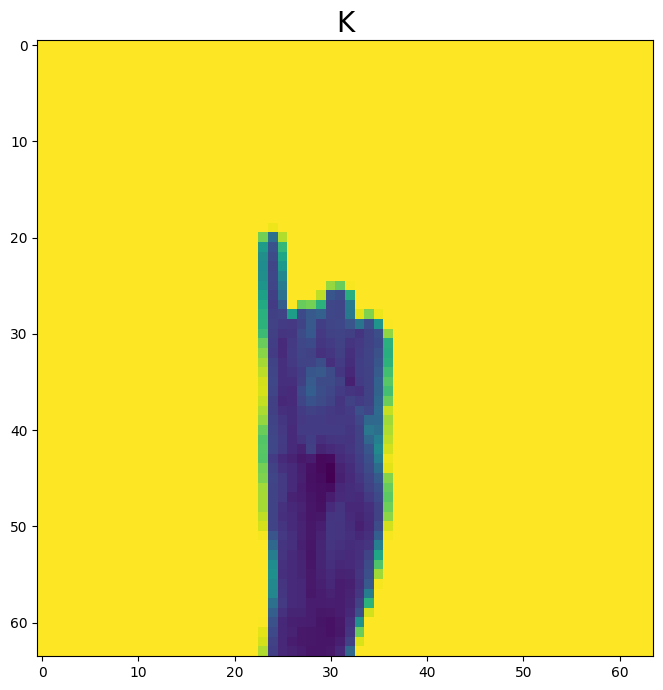

In [45]:
plt.figure(figsize=(25,8))
plt.imshow(X[66].reshape(w,h))
plt.title(enc.inverse_transform(y[0].reshape(1,10))[0][0],size = 20)
plt.show()

In [46]:
from keras.models import Model
from matplotlib.pyplot import figure
from numpy import expand_dims
def image_transform_gray(image):
    img = expand_dims(image, axis=0)
    model1 = Model(inputs=model.inputs, outputs=model.layers[0].output)
    feature_maps = model1.predict(img)
    figure(num=None, figsize=(25, 30), dpi=80, facecolor='w', edgecolor='k')
    square = 4
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(feature_maps[0, :, :, ix-1],cmap='gray')
            ix += 1
    # show the figure
    pyplot.show()
def image_transform(image):
    img = expand_dims(image, axis=0)
    model1 = Model(inputs=model.inputs, outputs=model.layers[0].output)
    feature_maps = model1.predict(img)
    figure(num=None, figsize=(25, 30), dpi=80, facecolor='w', edgecolor='k')
    square = 4
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(feature_maps[0, :, :, ix-1])
            ix += 1
    # show the figure
    pyplot.show()

1/1 [==============================] - 0s 114ms/step


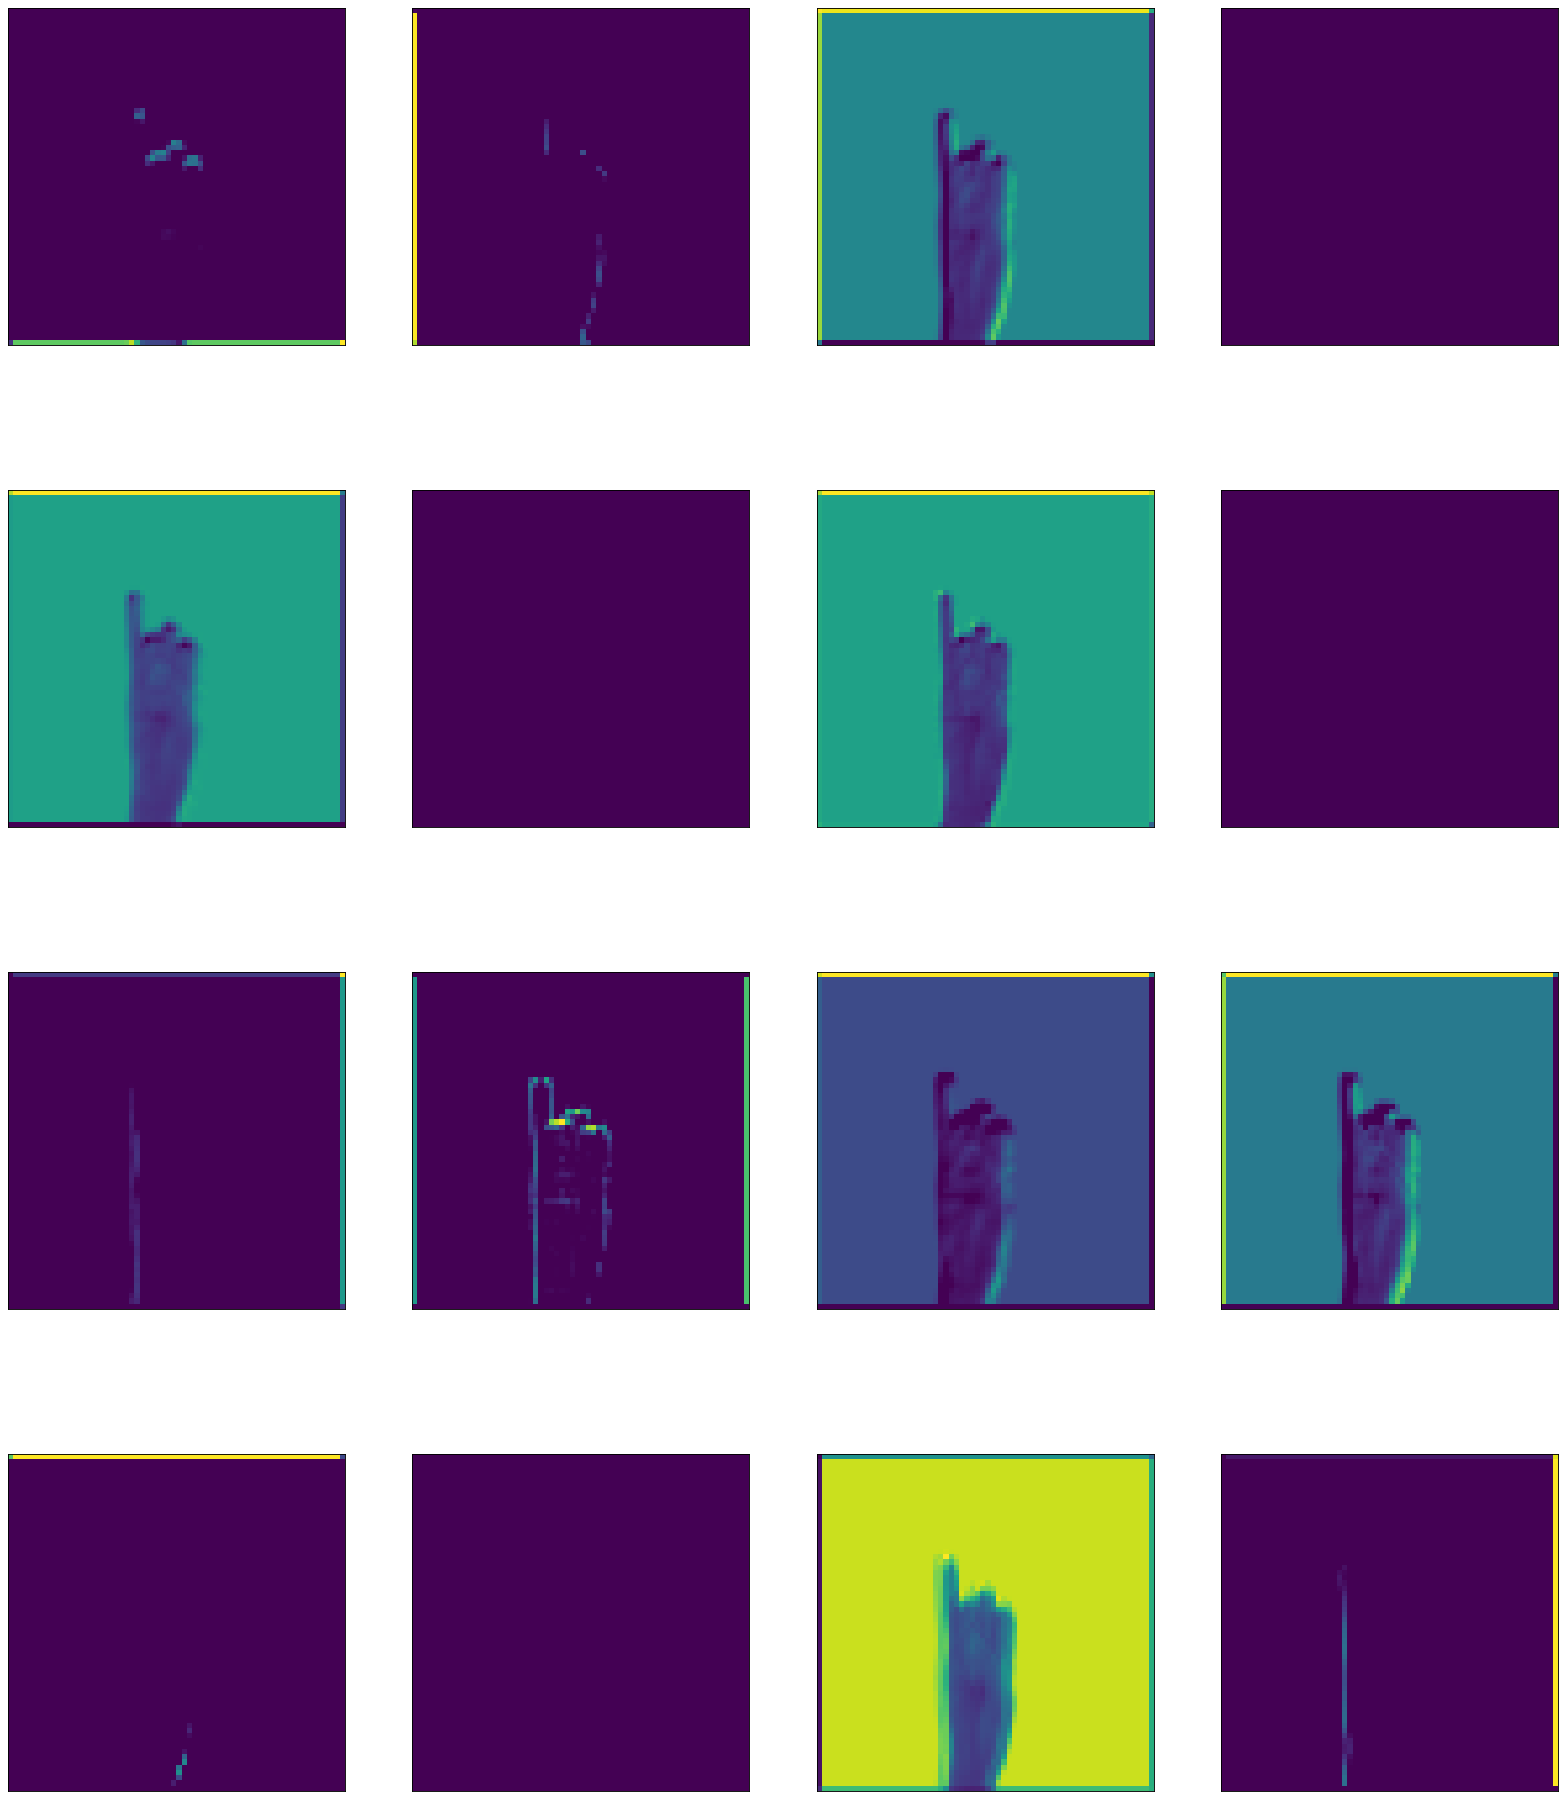

1/1 [==============================] - 0s 38ms/step


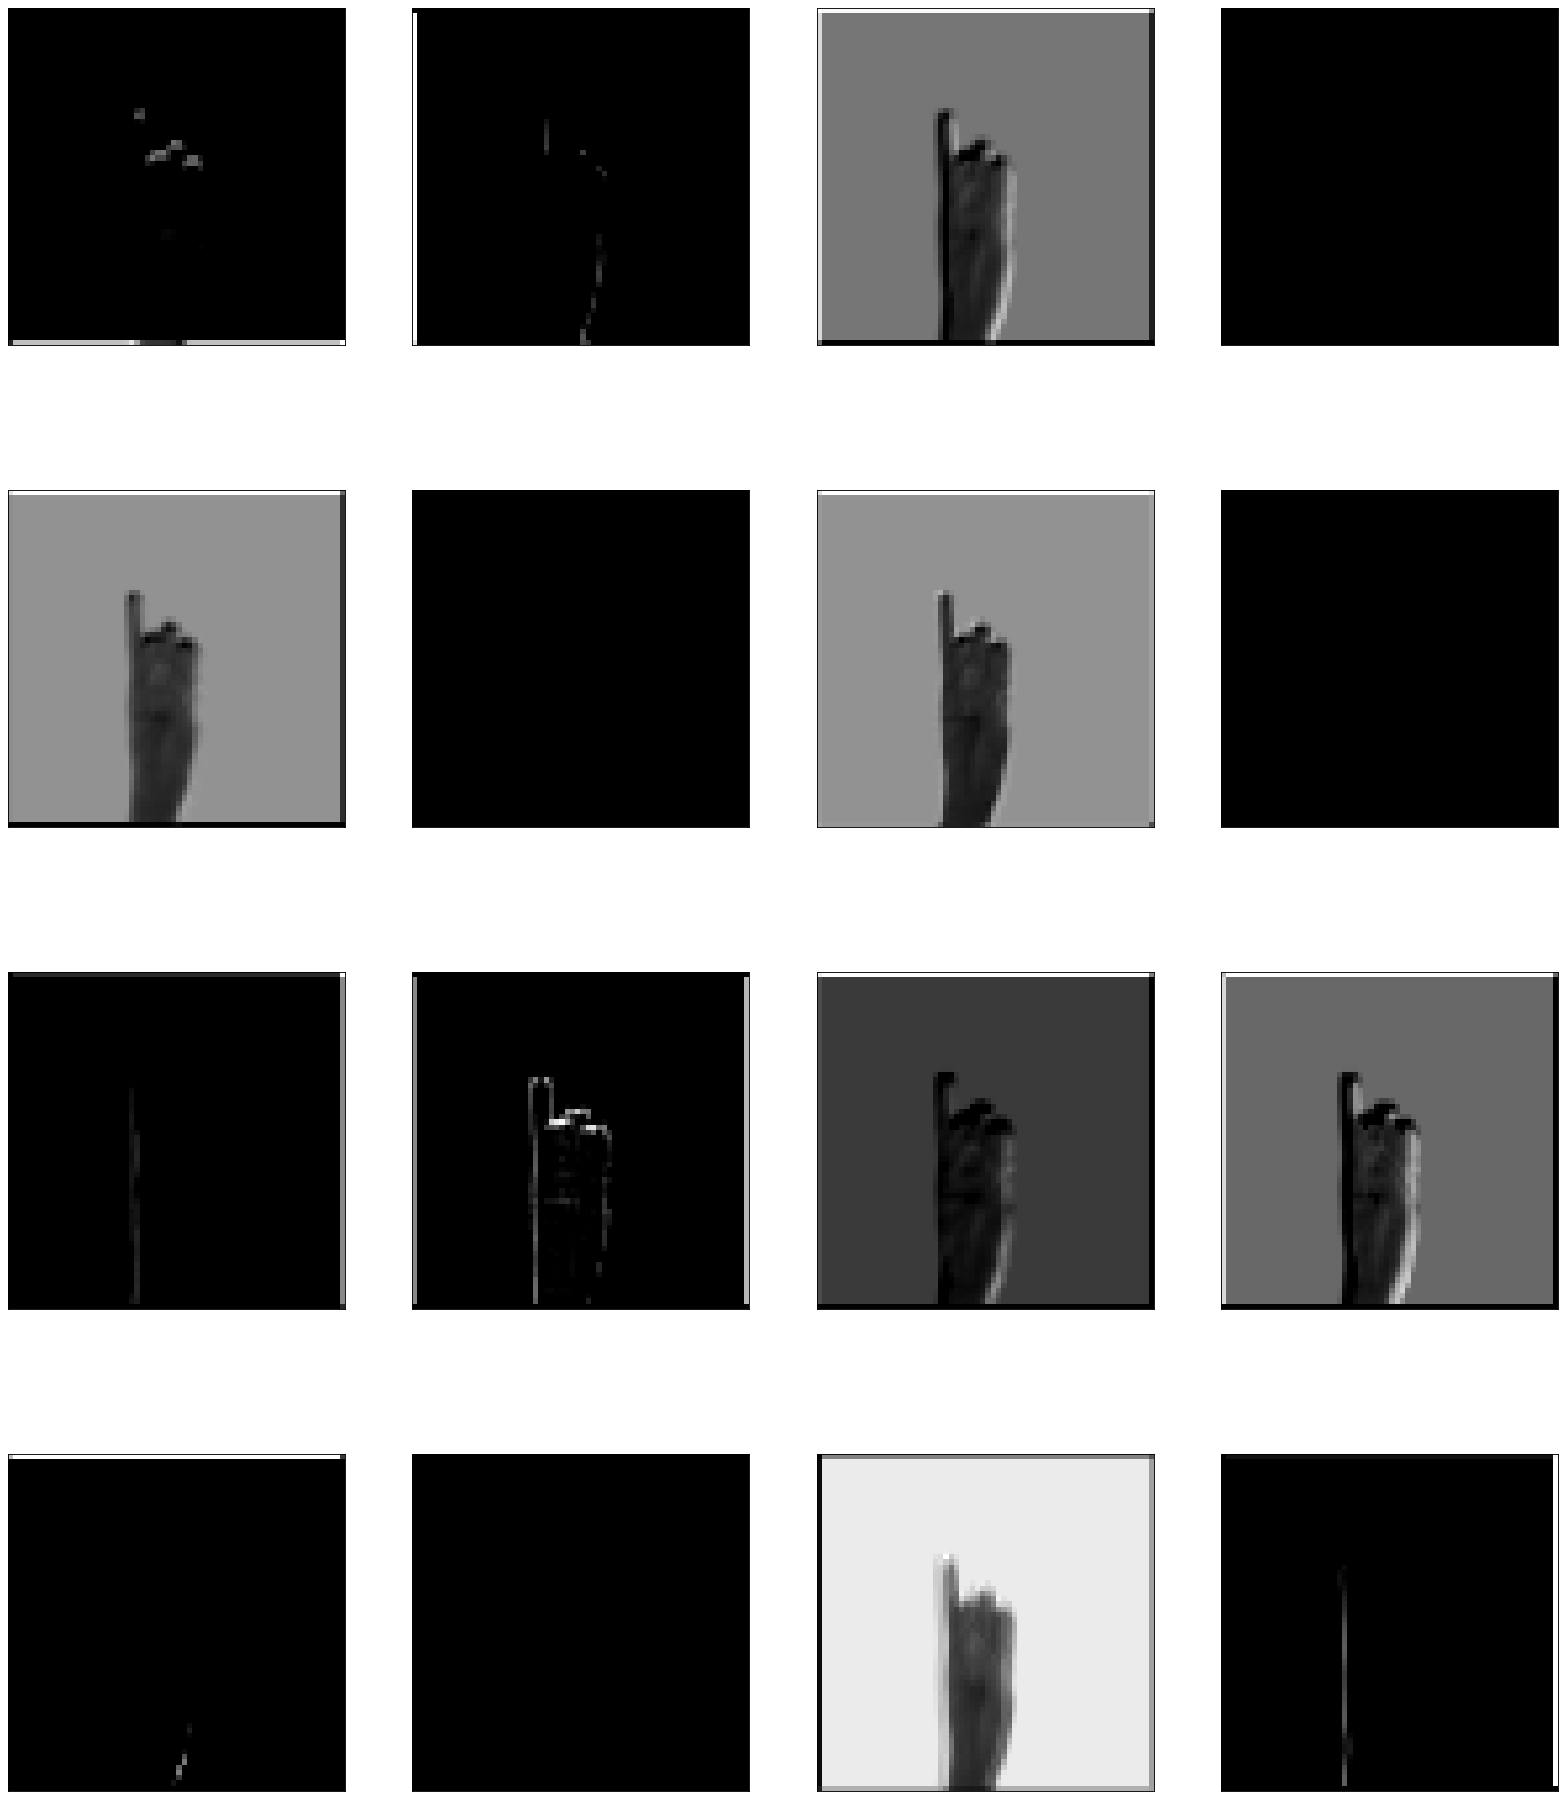

In [47]:
image_transform(X[66])
image_transform_gray(X[66])

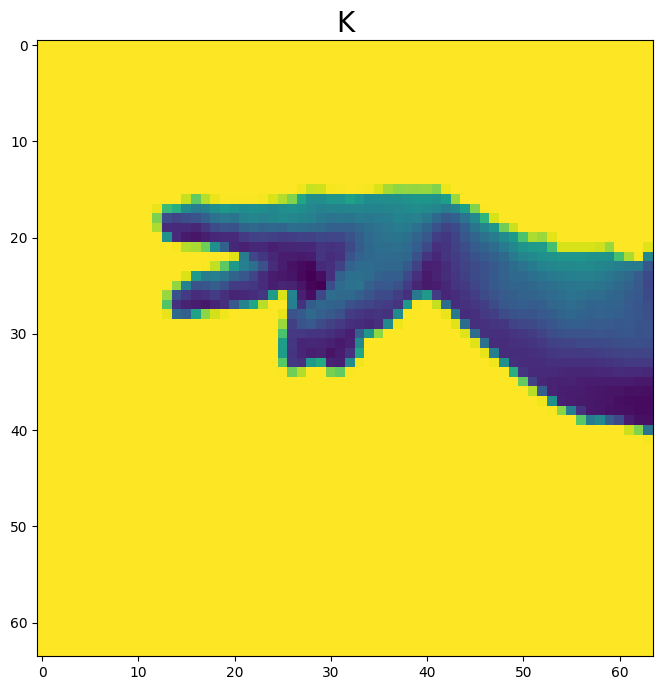

In [48]:
plt.figure(figsize=(25,8))
plt.imshow(X[56].reshape(w,h))
plt.title(enc.inverse_transform(y[0].reshape(1,26))[0][0],size = 20)
plt.show()

1/1 [==============================] - 0s 40ms/step


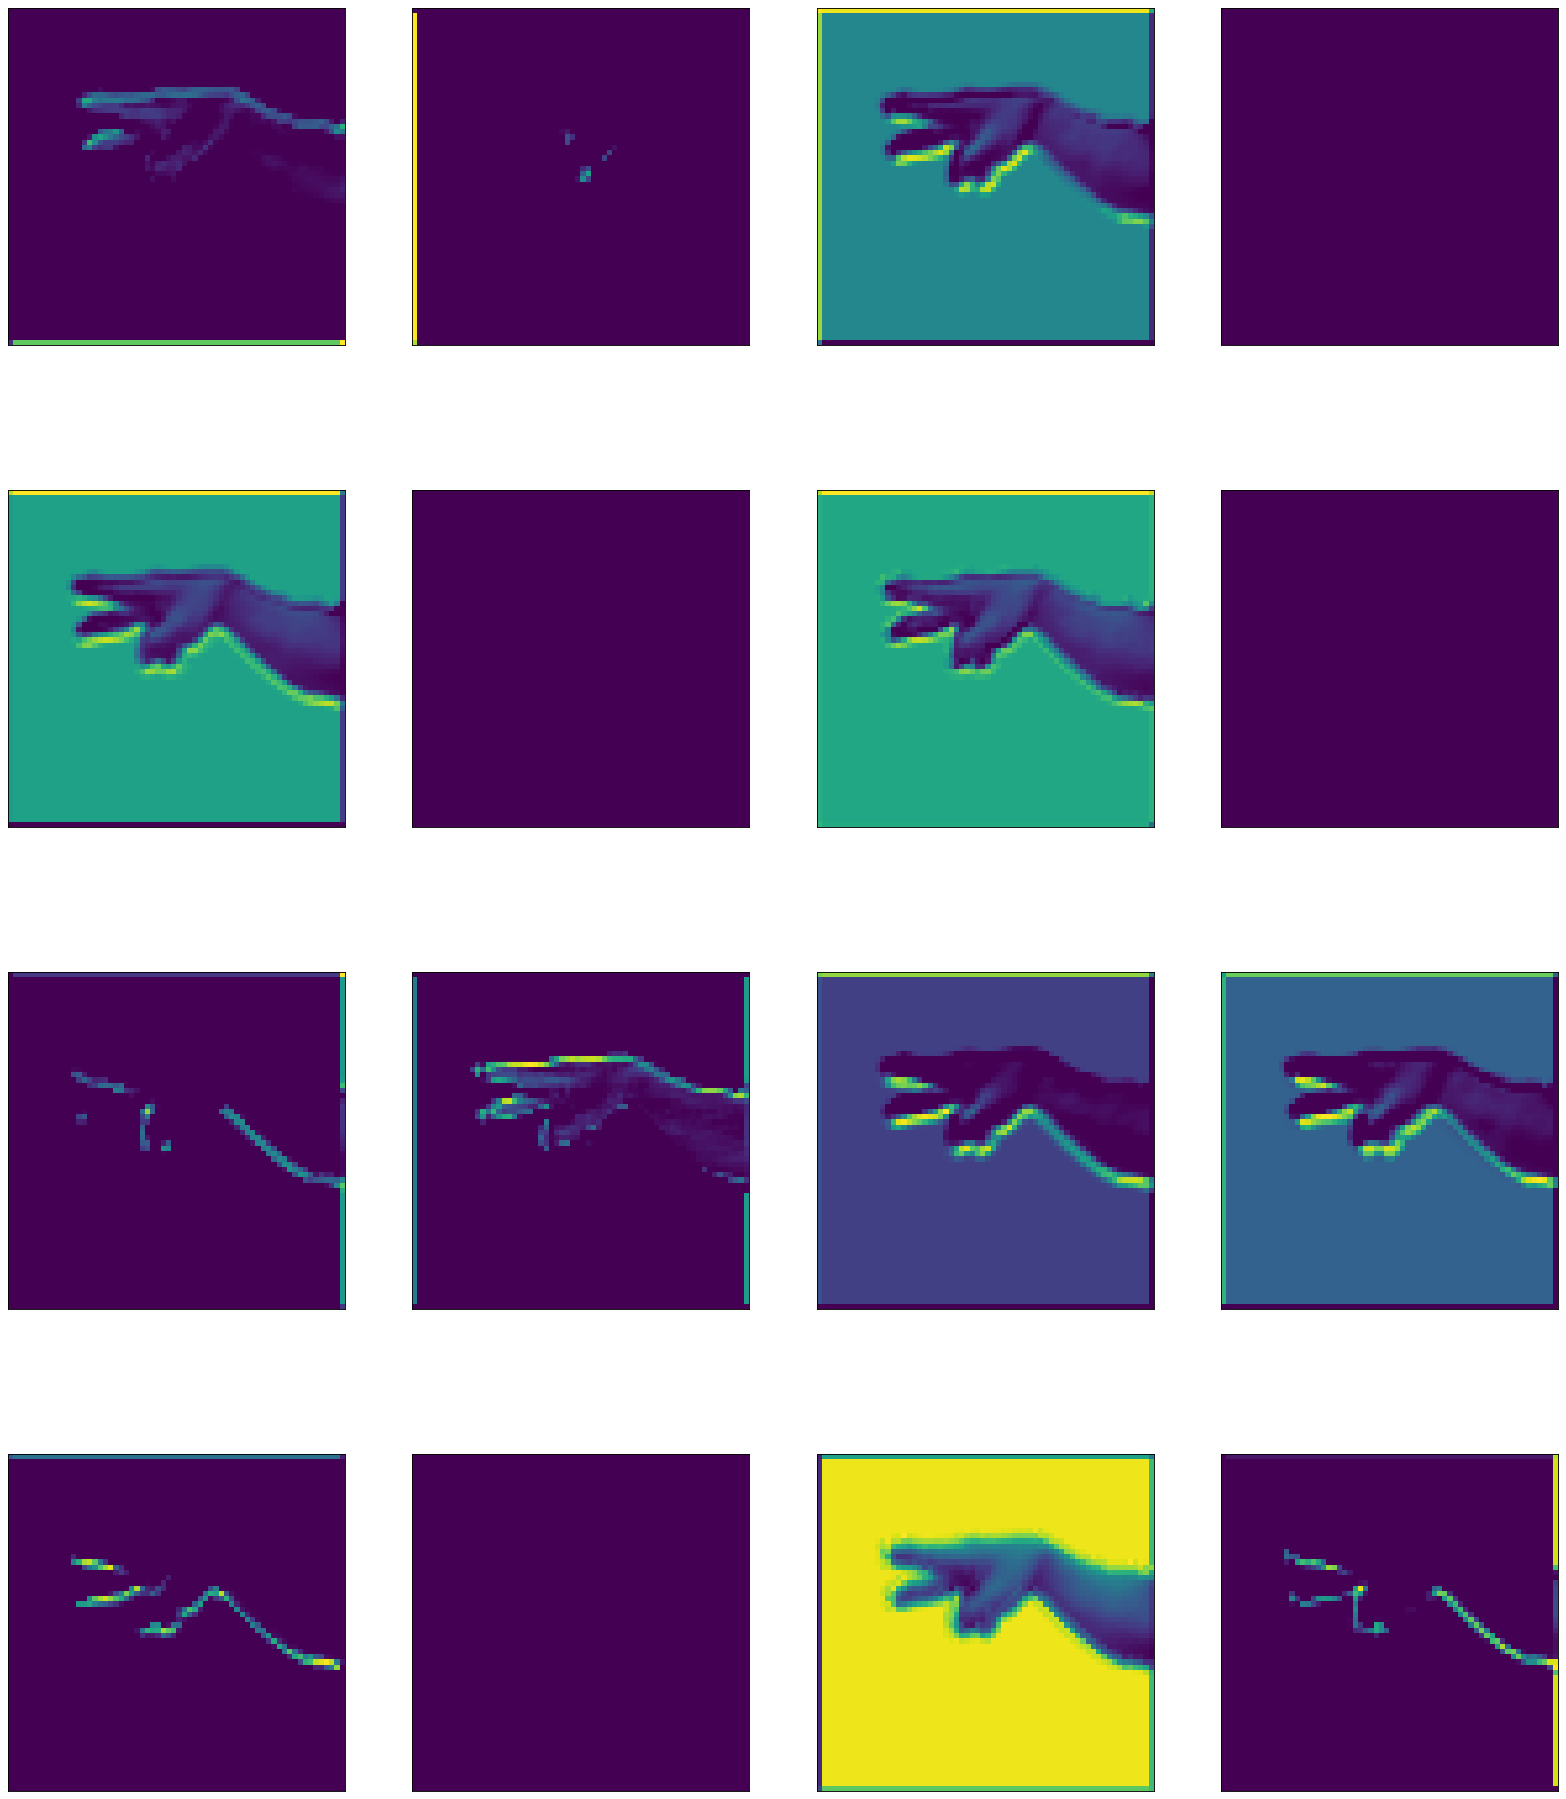

1/1 [==============================] - 0s 39ms/step


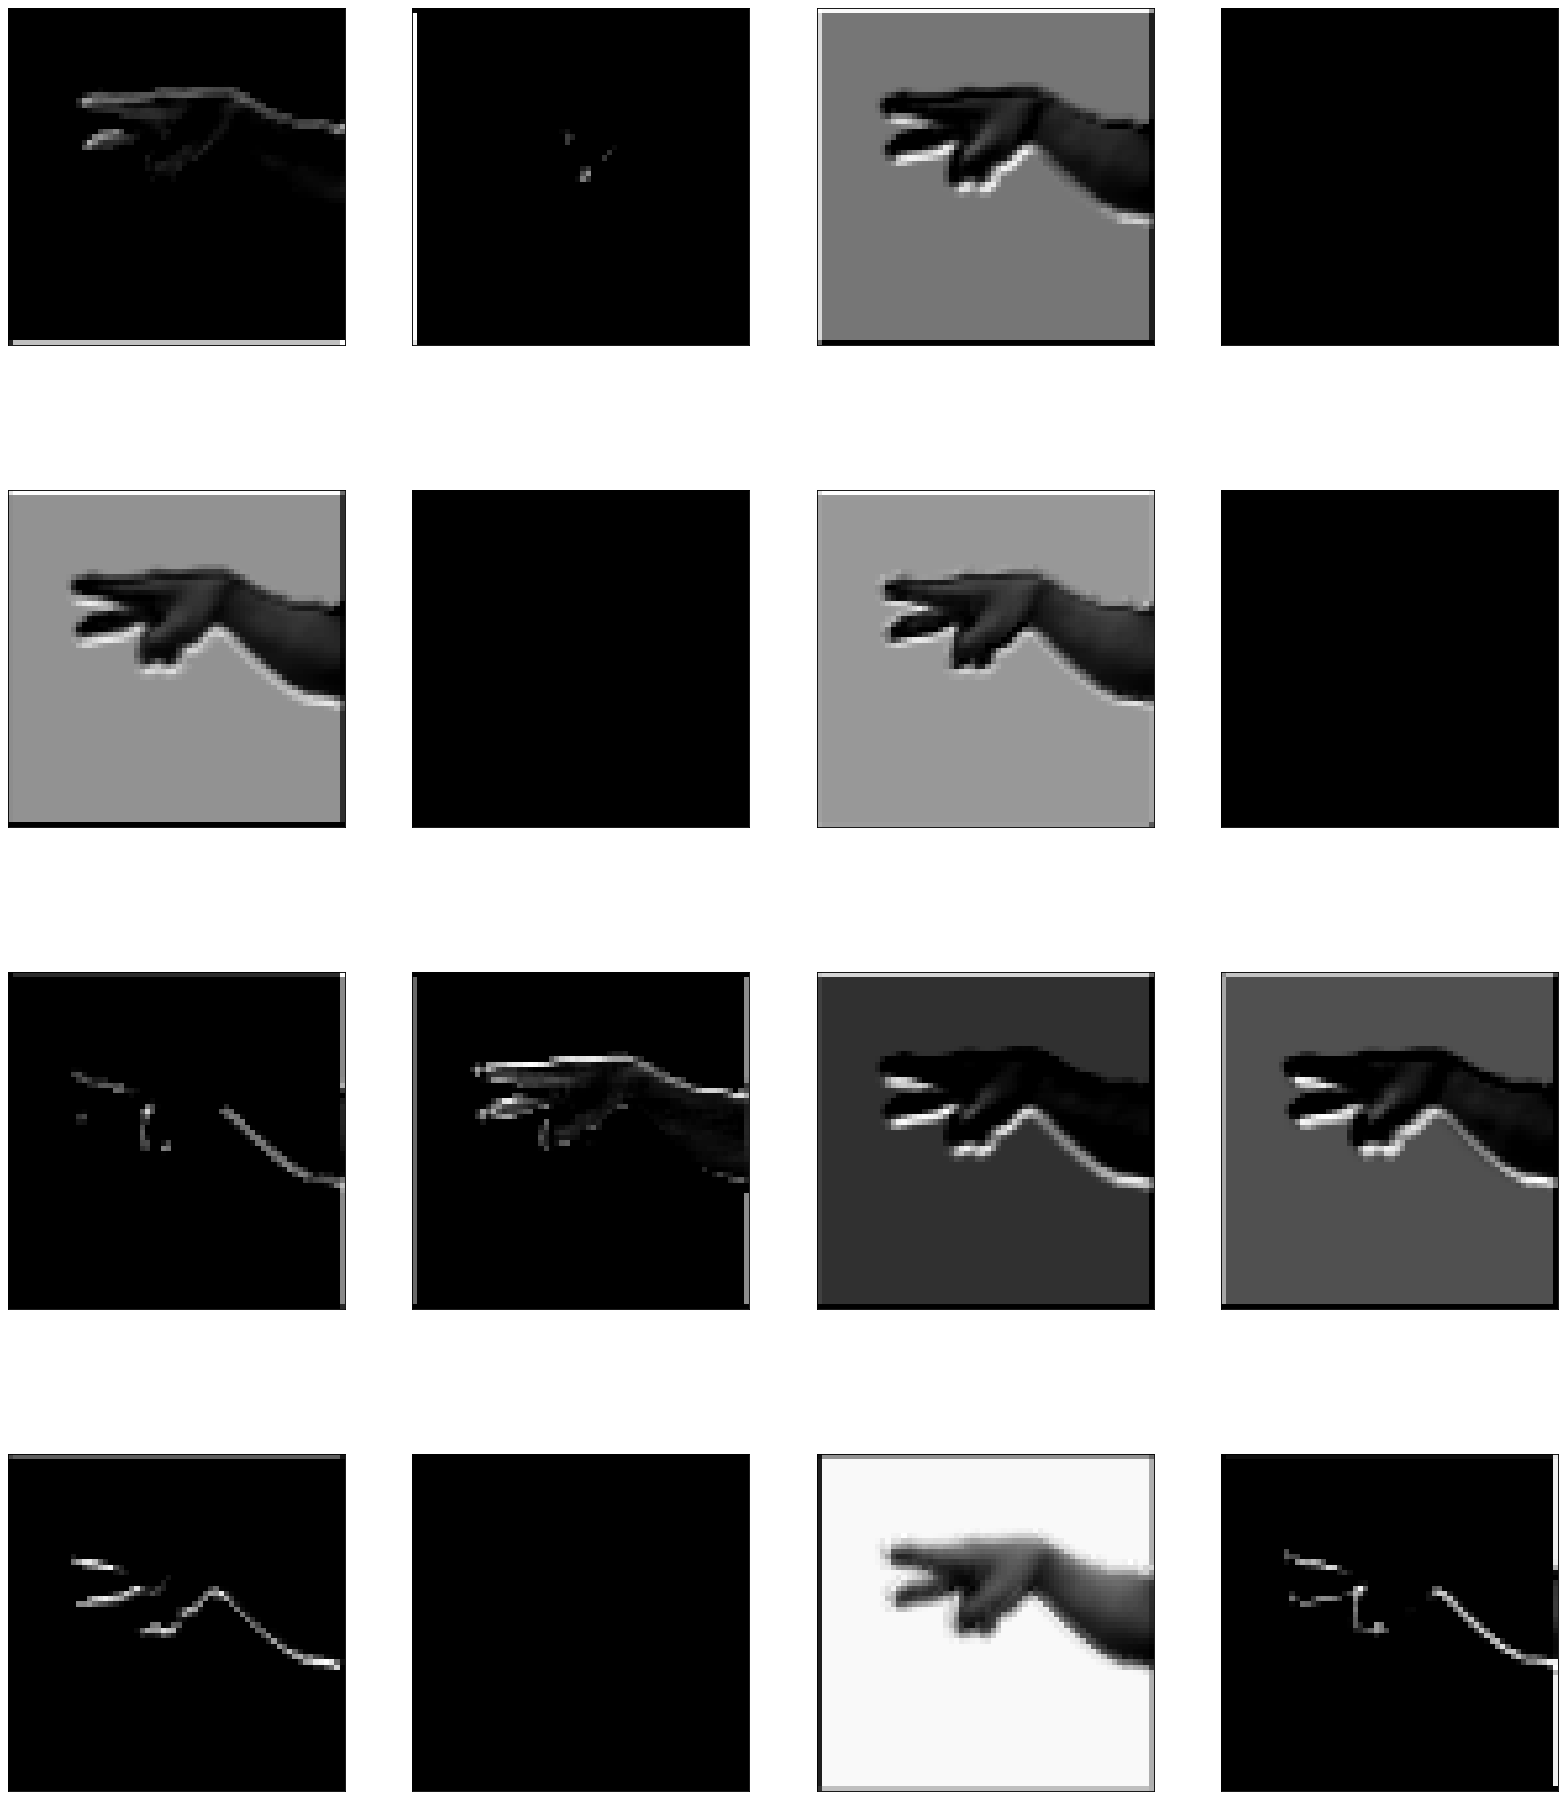

In [49]:
image_transform(X[56])
image_transform_gray(X[56])

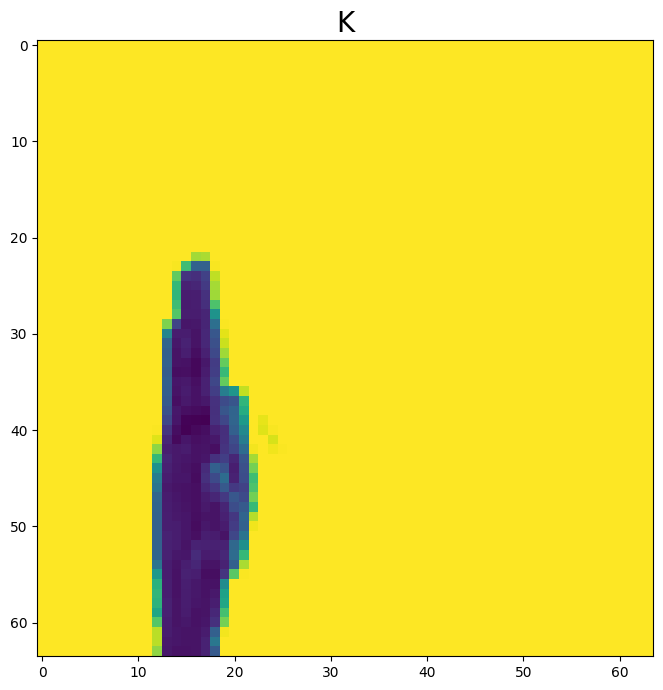

In [50]:
plt.figure(figsize=(25,8))
plt.imshow(X[1566].reshape(w,h))
plt.title(enc.inverse_transform(y[0].reshape(1,26))[0][0],size = 20)
plt.show()

1/1 [==============================] - 0s 40ms/step


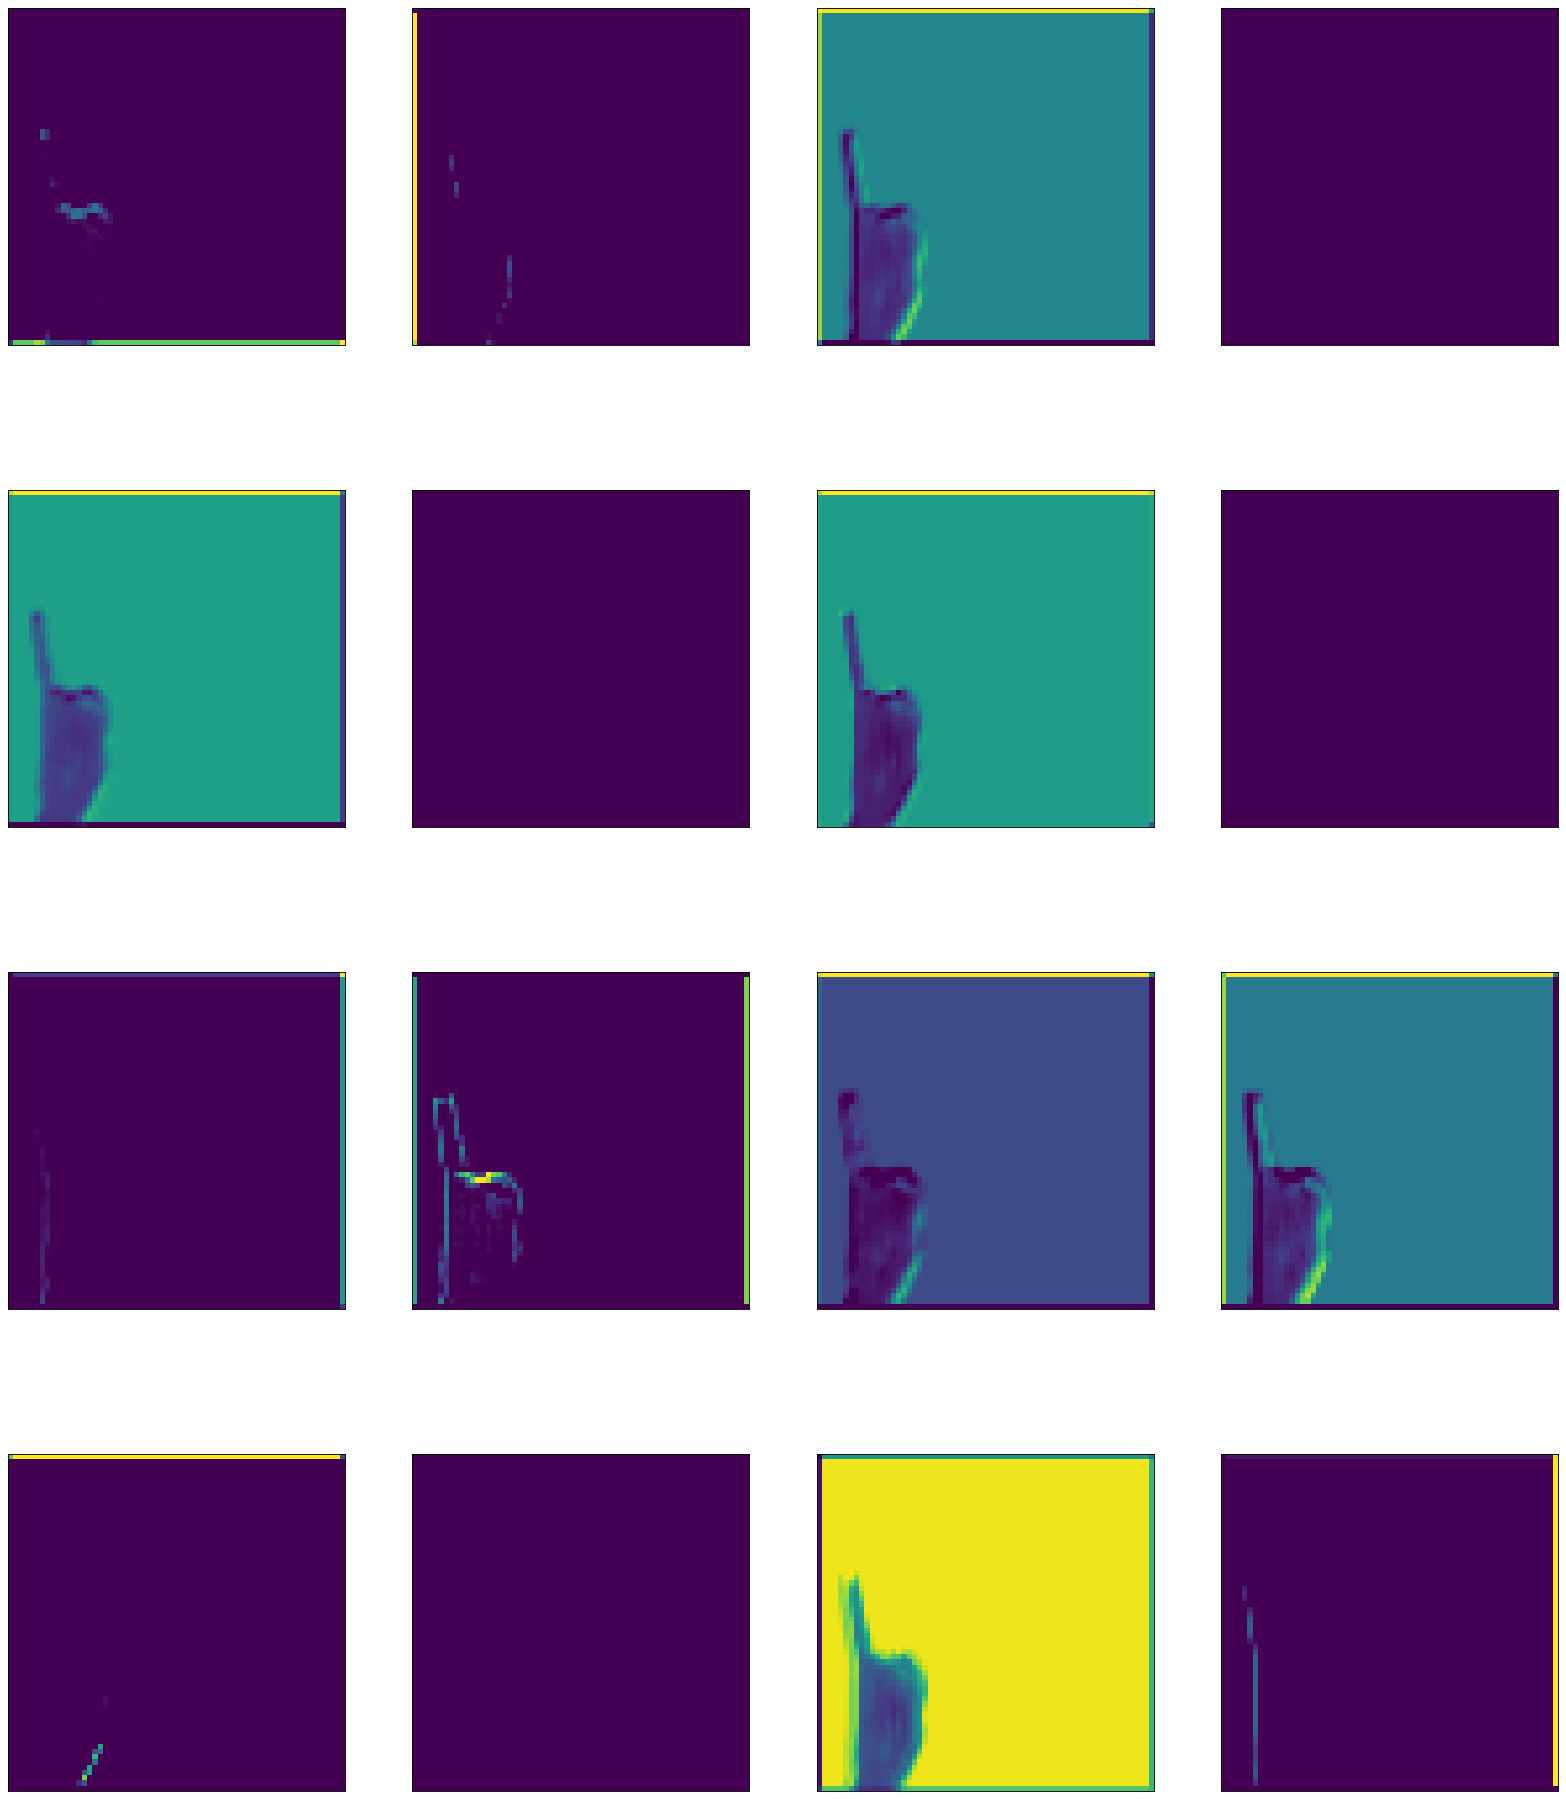

1/1 [==============================] - 0s 54ms/step


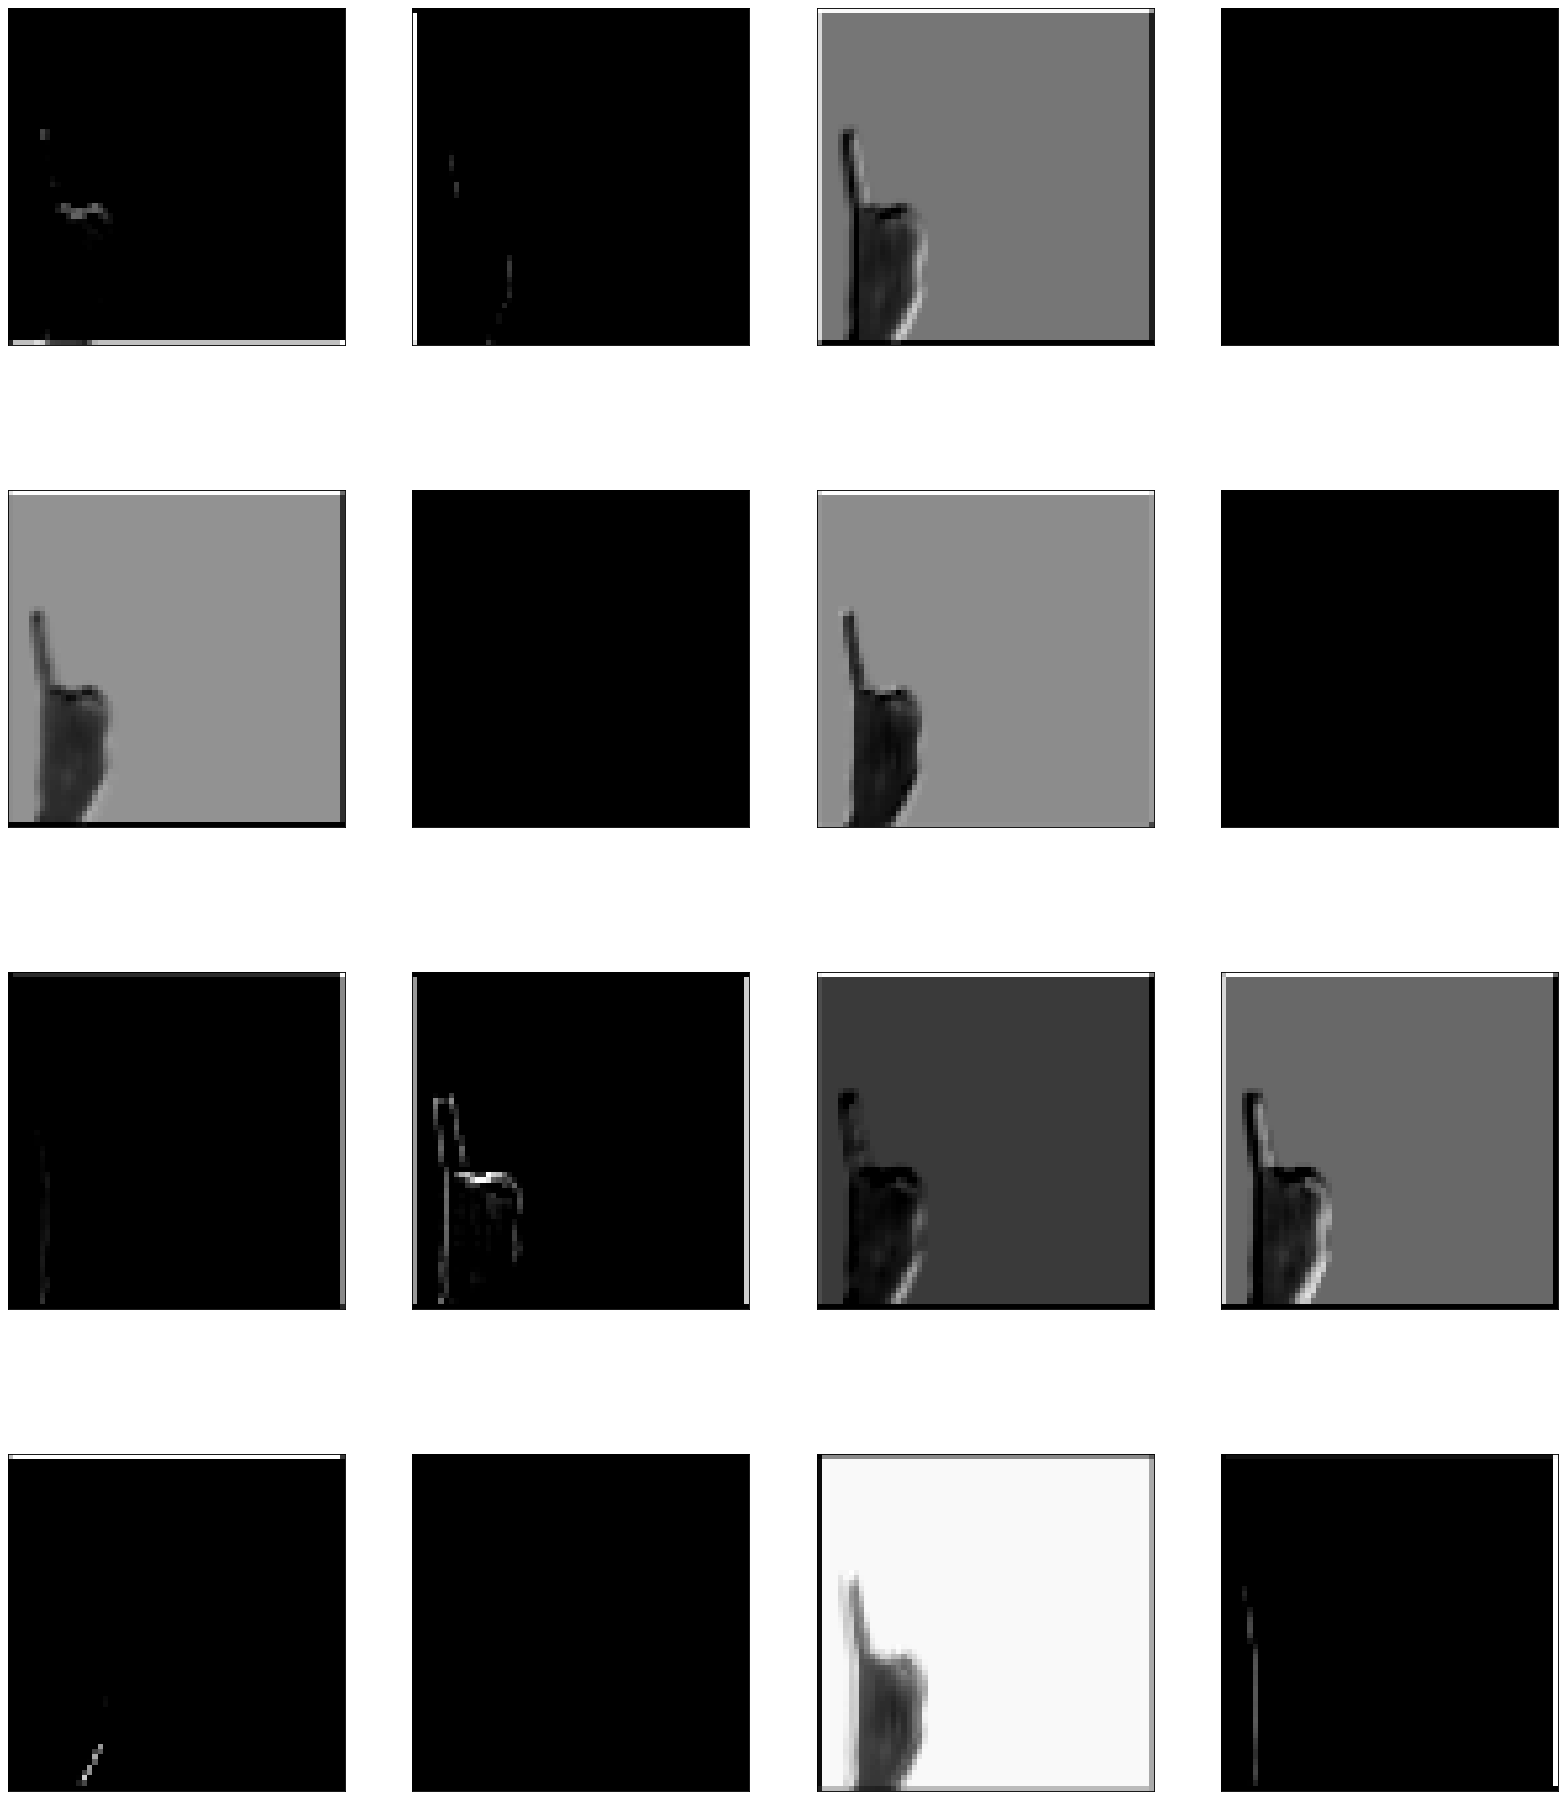

In [51]:
image_transform(X[156])
image_transform_gray(X[156])

TEST THE **RESULTS**

---



---



---



In [52]:
y_pred = model.evaluate(X_test,y_test,verbose = 1)

27/27 [==============================] - 1s 15ms/step - loss: 2.7661 - accuracy: 0.1643 - precision: 0.0459 - recall: 0.7818


In [53]:
y_pred[1]

0.1642685830593109

In [54]:
history.history['loss'][49]
import plotly.graph_objects as go


fig = go.Figure(data=[
    go.Bar(name = 'Accuracy',x=['Training','Validation','Real World Data'], y=[history.history['accuracy'][49] ,history.history['val_accuracy'][49],y_pred[1] ]),
    go.Bar(name = 'Precision',x=['Training','Validation','Real World Data'], y=[history.history['precision'][49] ,history.history['val_precision'][49],y_pred[2] ]),
    go.Bar(name = 'Loss',x=['Training','Validation','Real World Data'], y=[history.history['loss'][49] ,history.history['val_loss'][49],y_pred[0] ]),

])
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_yaxes(type = "log")
pyo.iplot(fig, filename = 'Act_train_rec')

In [55]:
model.predict(X_test)

27/27 [==============================] - 1s 4ms/step


array([[8.9208043e-01, 5.9431046e-01, 9.2215335e-01, ..., 9.7028697e-01,
        9.6757311e-01, 9.7740448e-01],
       [9.9872261e-01, 9.8634702e-01, 9.8734426e-01, ..., 9.9393809e-01,
        9.9169320e-01, 9.7981662e-01],
       [2.3192536e-08, 8.6912678e-08, 5.2547062e-08, ..., 7.2706541e-08,
        3.3186545e-09, 5.7930845e-07],
       ...,
       [2.5490874e-01, 8.4567016e-01, 4.2941120e-01, ..., 4.7409654e-01,
        4.0047511e-01, 4.0947801e-01],
       [4.2641632e-02, 3.3361956e-02, 3.8077082e-02, ..., 7.4911642e-01,
        4.6697682e-01, 9.4059068e-01],
       [1.2348906e-01, 4.9847394e-02, 7.0171990e-02, ..., 5.5804616e-01,
        7.7120769e-01, 8.2457560e-01]], dtype=float32)

In [81]:
y_pred

[2.7660579681396484,
 0.1642685830593109,
 0.045896101742982864,
 0.7817745804786682]

In [56]:
y_prediction = model.predict(X_test)
def binary_classify(y_pred):
    for inp in y_pred:
        maximum = 0
        index = 0
        for i in range(26):
            if(maximum != max(maximum,inp[i])):
                maximum = max(maximum,inp[i])
                index = i
            inp[i] = 0
        inp[index]=1
    return y_pred
y_prediction  = binary_classify(y_prediction)


27/27 [==============================] - 0s 4ms/step


In [57]:
print(enc.inverse_transform(y_test[1].reshape(1,26))[0][0])

E


In [58]:
print(y_prediction)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


In [59]:
def create_result(y):
    y_final = []
    for i in range(y.shape[0]):
        y_final.append(enc.inverse_transform(y[i].reshape(1,26))[0][0])
    return y_final
def remove_none(y , y_pred):
    index = []
    for i in range(len(y)-1,0,-1):
        if y_pred[i] == None :
            del y[i]
            del y_pred[i]

    return y , y_pred
def label_encode(y , y_pred):
    le = preprocessing.LabelEncoder()
    le.fit(y_pred)
    print(le.classes_)
    y = le.transform(y)
    y_pred = le.transform(y_pred)
    return y , y_pred

y_class_result = create_result(y_prediction)
y_class_desired = create_result(y_test)

In [61]:
y_label_desired , y_label_result = label_encode(y_class_desired , y_class_result)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


In [62]:
from sklearn.metrics import classification_report
tn = []
for cat in enc.categories_[0].reshape(26,1):
    tn.append(cat[0])
target_names = tn
print(classification_report(y_label_desired, y_label_result, target_names=target_names))

              precision    recall  f1-score   support

           A       0.16      0.09      0.12        32
           B       1.00      0.03      0.06        32
           C       0.10      0.03      0.05        32
           D       0.00      0.00      0.00        32
           E       0.30      0.09      0.14        32
           F       0.33      0.03      0.06        32
           G       0.12      0.12      0.12        34
           H       0.14      0.03      0.05        32
           I       0.09      0.12      0.10        32
           J       0.34      0.41      0.37        32
           K       0.15      0.12      0.14        32
           L       0.10      0.22      0.14        32
           M       1.00      0.03      0.06        32
           N       0.23      0.56      0.33        32
           O       0.39      0.22      0.28        32
           P       0.24      0.38      0.30        32
           Q       0.22      0.22      0.22        32
           R       0.15    

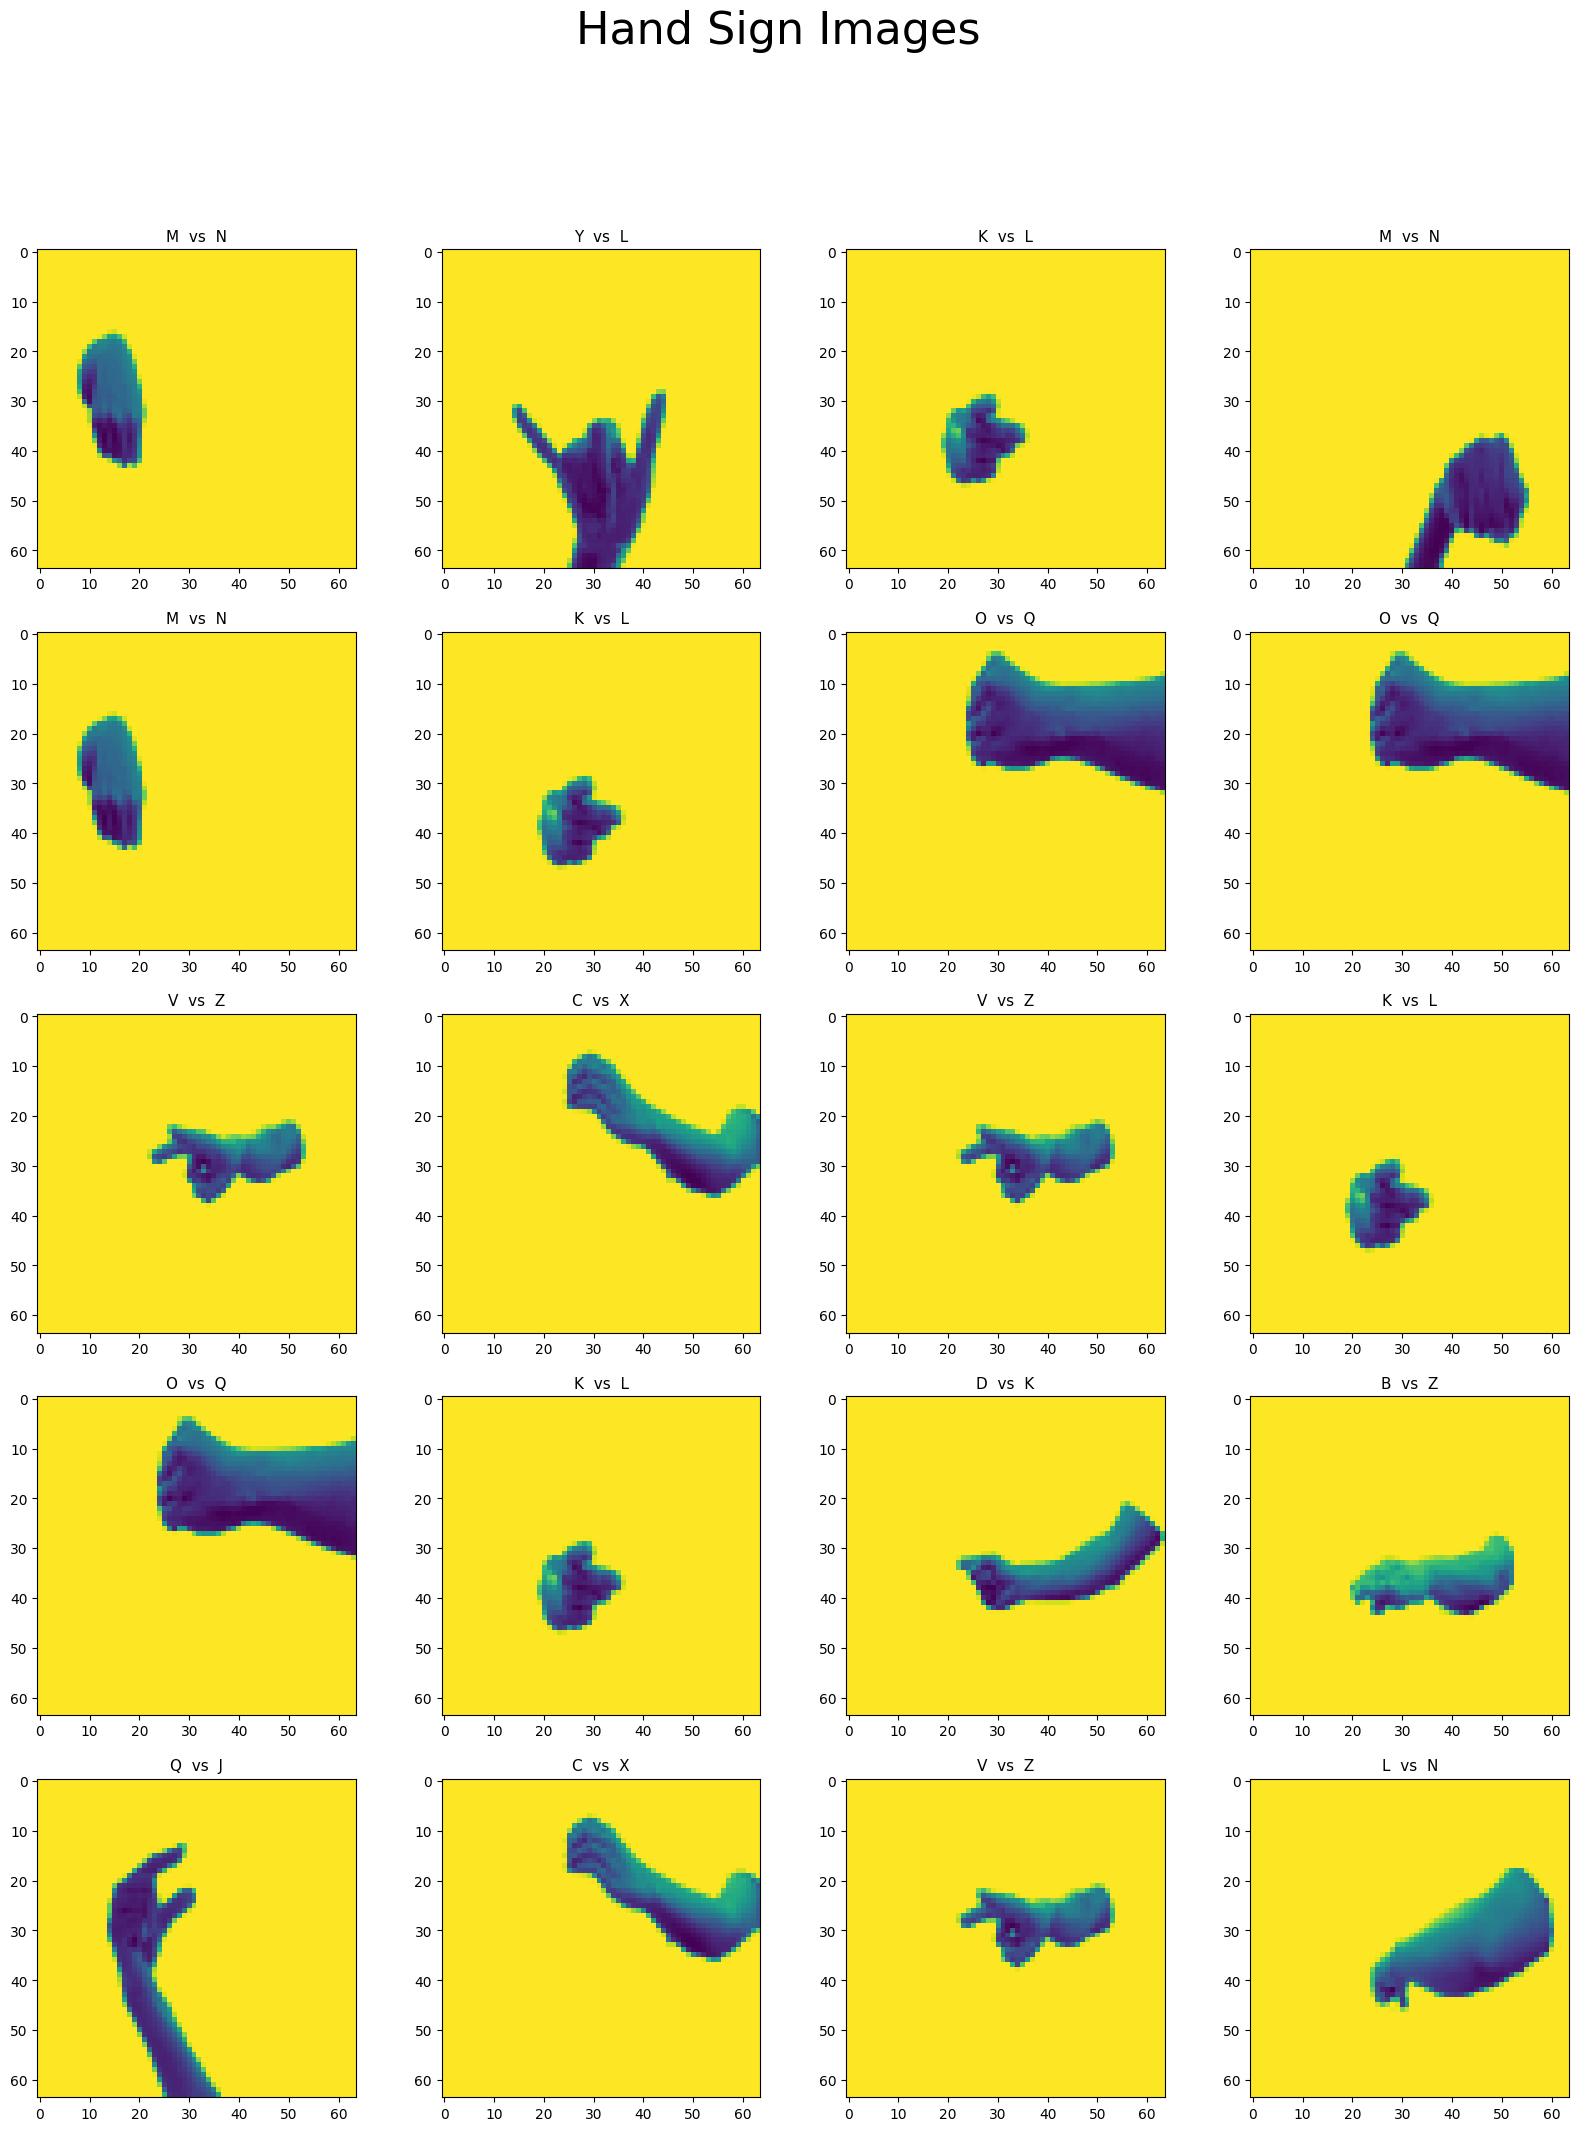

In [63]:
count = 1
f = plt.figure(figsize=(20,24))
for i in range(20):
    ind = random.sample(list(y_label_result),1)[0]
    img = X_test[ind]
    Class = str(y_class_desired[ind]) + '  vs  '+str(y_class_result[ind])
    ax = f.add_subplot(5, 4,count)
    ax = plt.imshow(img.reshape(w,h))
    ax = plt.title(Class,fontsize= 11)
    count = count + 1
plt.suptitle("Hand Sign Images", size = 32)
plt.show()